In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

In [3]:
#Coletando dados 

df = pd.read_excel('/home/andre/Downloads/RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_mex_ind = pd.DataFrame(df[['Ano','Mexilhao_ind']])
dados = df_mex_ind.dropna()

anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2001])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

pesca = dados['Mexilhao_ind'].values

In [4]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

pesca_mean = np.mean(pesca)
pesca_std = np.std(pesca)
pesca_norm = (pesca - pesca_mean)/pesca_std

In [5]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse')
model.fit(anos_com_dados_norm,pesca_norm, epochs=500, verbose=1)
model.save_weights('/home/andre/Área de Trabalho/Projeto da pesca/Rio de Janeiro/Moluscos/Mexilhão/pesos pesca ind/.weights.h5', overwrite=True)

Epoch 1/500


/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step - loss: 1.0010
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9641
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9286
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8902
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8493
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8043
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7555
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7040
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6524
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6046
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5661
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5433
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5393
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5414
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5323
Epoch 16/500
1/1 ━━━━━━━━━━━━━

In [6]:
#Pegando ospesos salvos
model.load_weights('/home/andre/Área de Trabalho/Projeto da pesca/Rio de Janeiro/Moluscos/Mexilhão/pesos pesca ind/.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[1.0184182]
 [1.0429615]
 [1.0763341]
 [1.1202371]
 [1.1725332]
 [1.2392777]
 [1.3181136]
 [1.3961368]
 [1.4750005]
 [1.5466455]
 [1.6208379]
 [1.677453 ]
 [0.674293 ]]


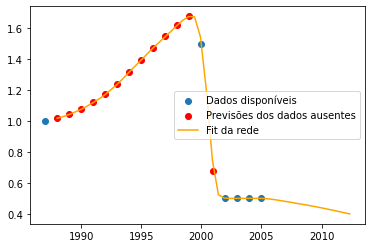

In [7]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*pesca_std + pesca_mean
prev_ausentes = model.predict(anos_para_prever_norm)*pesca_std + pesca_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,pesca,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*pesca_std + pesca_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

In [8]:
#Planilha com os dados preenchidos

df_previsoes = pd.DataFrame({'Ano':anos_para_prever, 'Mexilhao_ind':prev_ausentes.flatten()})

df_preenchido = pd.concat((dados,df_previsoes)).sort_values('Ano')

df_preenchido

,Ano,Mexilhao_ind
37,1987,1.000000
0,1988,1.018418
1,1989,1.042961
2,1990,1.076334
3,1991,1.120237
4,1992,1.172533
5,1993,1.239278
6,1994,1.318114
7,1995,1.396137
8,1996,1.475001
